#### EXAMPLES

Dependencies and preliminaries

In [1]:
using ModelingToolkit, Plots, DifferentialEquations, Revise, Unitful, CoolProp,  Logging,NonlinearSolve, Printf
using Revise
using Symbolics, XSteam


In [4]:
include("03-MTK_UTILS.jl")
@variables t
Revise.retry()
module Gas
    include("01-ThermoGas.jl")
end

module Steam
    include("01-MultiPhase.jl")
end
module Steam
    include("01-MultiPhase.jl")
end
module Liq
    include("01-Incompressible.jl")
end
module Gas
    include("01-ThermoGas.jl")
end

Main.Gas

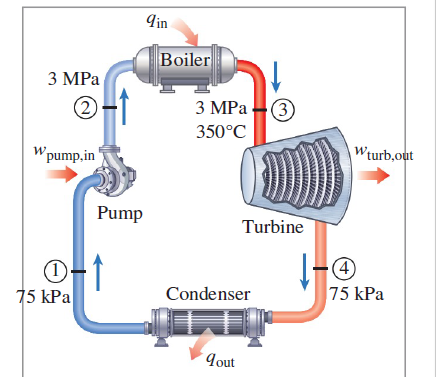

In [5]:
@named WorkRes     = Steam.WorkPin()
@named ColdUtil    = Steam.HeatTransferPin()
@named HotUtil     = Steam.HeatTransferPin()

sysnames(x) = display([s.name for s in x.systems])
Tmax = 350+273.15;
Pmax = 30;  #   Bar
Pmin = 7.5; #   Bar

@named Ref        = Steam.ioReservoir(P=Pmin, fixboth = true)
@named valve      = Steam.SteamFlowSource(ṁ = 1.0)
@named pump       = Steam.AdiabaticPump(Pout = Pmax, setpressure =true)
@named boiler     = Steam.IdealBoiler(Tout = Tmax)
@named turbine    = Steam.AdiabaticTurbine(setpressure = false, Pout = Pmin)
@named condensor  = Steam.IdealCondensor()

systems = [Ref, valve, pump, boiler, turbine, condensor, WorkRes, ColdUtil, HotUtil];
connections = vcat(Steam.hydro_connect(Ref.n,valve.p),
                    Steam.hydro_connect(valve.n,pump.p),
                    Steam.hydro_connect(pump.n, boiler.p),
                    Steam.hydro_connect(boiler.n, turbine.p),
                    Steam.hydro_connect(turbine.n, condensor.p),
                    Steam.hydro_connect(condensor.n, Ref.p),
                    work_connect(WorkRes, turbine.w, pump.w),
                    heat_connect(ColdUtil, condensor.q),
                    heat_connect(HotUtil, boiler.q));

@named ODESYS = ODESystem(connections, t; systems = systems)
@named evalsys = ODESystem(substitute(equations(ODESYS),Steam.hydro_prop_dict),t)
simple_sys = structural_simplify(evalsys)

tspan = (0.0,1.0)
ode_prob = ODEProblem(simple_sys,[],tspan,)
sol = solve(ode_prob)

display(sol[WorkRes.Ẇ])
display(sol[ColdUtil.Q̇])
display(sol[HotUtil.Q̇])

showsol( [Ref, valve, pump, boiler, turbine, condensor, WorkRes, ColdUtil, HotUtil],sol)

2-element Vector{Float64}:
 1.2545310443805167e6
 1.2545310443805167e6

2-element Vector{Float64}:
 1.1521432090359975e6
 1.1521432090359975e6

2-element Vector{Float64}:
 -2.406674253416514e6
 -2.406674253416514e6

	 Ref₊p ṁ = 1.00 	 P =  7.50 	 T = 440.93 
	 Ref₊n ṁ = -1.00 	 P =  7.50 	 T = 440.93 
	 valve₊p ṁ = 1.00 	 P =  7.50 	 T = 440.93 
	 valve₊n ṁ = -1.00 	 P =  7.50 	 T = 440.93 
	 pump₊p ṁ = 1.00 	 P =  7.50 	 T = 440.93 

 Ẇ = 4.17e+00 
	 pump₊n ṁ = -1.00 	 P =  30.00 	 T = 440.64  Ẇ = 4.17e+00 
	 boiler₊p ṁ = 1.00 	 P =  30.00 	 T = 440.64  Q̇ = 2.41e+06 
	 boiler₊n ṁ = -1.00 	 P =  30.00 	 T = 623.15  Q̇ = 2.41e+06 
	 turbine₊p ṁ = 1.00 	 P =  30.00 	 T = 623.15  Ẇ = -1.25e+06 
	 turbine₊n ṁ = -1.00 	 P =  7.50 	 T = 440.91  Ẇ = -1.25e+06 
	 condensor₊p ṁ = 1.00 	 P =  7.50 	 T = 440.91  Q̇ = -1.15e+06 
	 condensor₊n ṁ = -1.00 	 P =  7.50 	 T = 440.93  Q̇ = -1.15e+06 


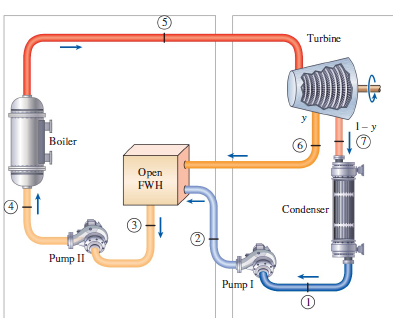

In [14]:
Pmid = 1
Pmin = 0.1
Pmax = 150

@named iores        = Steam.ioReservoir(P=Pmin, fixboth = false)
@named valve        = Steam.SteamFlowValve()
@named pumpB        = Steam.AdiabaticPump(Pout = Pmax,setpressure = true)
@named boil         = Steam.SteamHeatTransfer()
@named turbine      = Steam.SIMOAdiabaticTurbine(setpressure = true, Pyin = Pmid, Pzin = Pmin,ηin = 1.0) 
@named pumpA        = Steam.AdiabaticPump(Pout = 10, setpressure = true)
@named condensor    = Steam.IdealCondensor()
@named openfw       = Steam.OpenFeedwaterHeater()

connections = vcat(Steam.hydro_connect(pumpB.n,valve.p),
                    Steam.hydro_connect(valve.n, boil.p),
                    Steam.hydro_connect(boil.n, turbine.p),
                    Steam.hydro_connect(turbine.hp.n, openfw.y),
                    Steam.hydro_connect(turbine.lp.n, condensor.p),
                    Steam.hydro_connect(condensor.n,iores.p),
                    Steam.hydro_connect(iores.n,pumpA.p),
                    Steam.hydro_connect(pumpA.n,openfw.z),
                    Steam.hydro_connect(openfw.n,pumpB.p))

systems = [valve,boil,turbine,pumpB,iores,pumpA,condensor,openfw]
@named odesys = ODESystem(connections,t; systems = systems)

masfcn(t) = 100 + 15 * sin(t)
Qf(t) = 100e6 + 35e6 * cos(t)  

# @unpack valve, HeatIn, HeatTx, HeatRej,circulator = odesys
@unpack valve, boil, condensor, pumpA = odesys
controlled_eqs = [valve.p.ṁ ~ masfcn(t),
                    boil.Q̇ ~ Qf(t)]

@named aux_sys = ODESystem(controlled_eqs,t)
@named odesys = extend(odesys, aux_sys)

odesys = substitute(odesys,Steam.hydro_prop_dict)
simple_sys = structural_simplify(odesys)

saveat = LinRange(1.0,9.0,25)
kwargs = (abstol=1e-10, reltol=1e-10, saveat = saveat)
tspan = (0.0,10.0)

prob    = ODAEProblem(simple_sys,[],tspan,)
sol   = solve(prob, Rodas4(); kwargs...);




# p1 = plot(sol, vars = [valve.p.ṁ], title = "Cycle Flow Rate")
# p2 = plot(sol, vars = [boil.Q̇, condensor.Q̇], title = "Heat Loading")
# p3 = plot(sol,vars = [pumpA.w.Ẇ])
# p=plot(p1,p2,p3,layout = (3,1))


retcode: Success
Interpolation: 1st order linear
t: 25-element LinRange{Float64, Int64}:
 1.0,1.33333,1.66667,2.0,2.33333,2.66667,3.0,…,7.66667,8.0,8.33333,8.66667,9.0
u: 25-element Vector{Vector{Float64}}:
 []
 []
 []
 []
 []
 []
 []
 []
 []
 []
 ⋮
 []
 []
 []
 []
 []
 []
 []
 []
 []

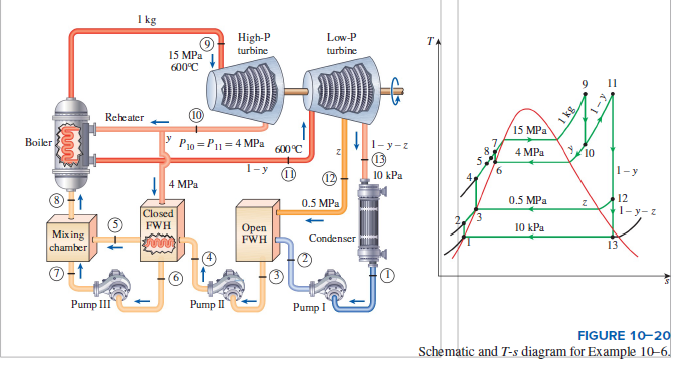

In [ ]:
@named iores        = Steam.ioReservoir(P=Pmin, fixboth = false)
@named valve        = Steam.SteamFlowValve()
@named pumpB        = Steam.AdiabaticPump(Pout = Pmax,setpressure = true)
@named boil         = Steam.SteamHeatTransfer()
@named turbine      = Steam.SIMOAdiabaticTurbine(setpressure = true, Pyin = Pmid, Pzin = Pmin,ηin = 1.0) 
@named pumpA        = Steam.AdiabaticPump(Pout = 10, setpressure = true)
@named condensor         = Steam.IdealCondensor()
@named openfw       = Steam.OpenFeedwaterHeater()

connections = vcat(Steam.hydro_connect(pumpB.n,valve.p),
                    Steam.hydro_connect(valve.n, boil.p),
                    Steam.hydro_connect(boil.n, turbine.p),
                    Steam.hydro_connect(turbine.hp.n, openfw.y),
                    Steam.hydro_connect(turbine.lp.n, condensor.p),
                    Steam.hydro_connect(condensor.n,iores.p),
                    Steam.hydro_connect(iores.n,pumpA.p),
                    Steam.hydro_connect(pumpA.n,openfw.z),
                    Steam.hydro_connect(openfw.n,pumpB.p))

systems =[valve,boil,turbine,pumpB,iores,pumpA,condensor,openfw]
ODESystem(connections,t;name = name, systems = systems)

In [19]:
using Unitful, CoolProp
fprops(end_prop, in_propA, A, in_unitA, in_propB, B, in_unitB) = PropsSI(end_prop,in_propA,A * in_unitA ,in_propB,B * in_unitB,"HE")

hpt(x,y) = fprops("HMASS","P", x, u"bar", "T", y, u"K").val
tph(x,y) = fprops("T","P", x, u"bar", "HMASS", y, u"J/K").val
sph(x,y) = fprops("SMASS",x, x, u"bar", "HMASS", y, u"J/K").val
vph(x,y) = 1/fprops("D", x, x, u"bar", "HMASS", y, u"J/K").val

hpt(30,350+273.15)


# Gas.testTurbine()

# "ISENTROPIC_EXPANSION_COEFFIECIENT(),"P", 30u"bar", "T", 500u"K", "He")
CoolProp.ISENTROPIC_EXPANSION_COEFFIECIENT("P", 30u"bar", "T", 500u"K", "He")


I

UndefVarError: UndefVarError: ISENTROPIC_EXPANSION_COEFFIECIENT not defined

In [ ]:


@named Ref        = Steam.Reservoir(P=Pmin)
@named valve      = Steam.SteamFlowSource(ṁ = 1.0)
@named pump       = Steam.AdiabaticPump(Pout = Pmax, setpressure =true)

connections = vcat(Steam.hydro_connect(Ref.n,valve.p),
                    Steam.hydro_connect(valve.n,pump.p))

@named tst = ODESystem(connections,t;systems = [Ref,valve,pump])

hydro_prop_dict_old = Dict(stm_Tpsfunc => T_ps,
                        stm_Tphfunc => T_ph,
                        stm_xphfunc => x_ph,
                        stm_sptfunc => s_pT,
                        stm_sphfunc => s_ph,
                        stm_hptfunc => h_pT,
                        stm_hpsfunc => h_ps,
                        stm_hsatfunc => hL_p,
                        stm_vphfunc => v_ph,
                        stm_cphfunc => Cp_ph);